In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np

noordering_path = os.path.join(
    os.path.dirname('__file__'),
    'out_data_noorder.csv'
)

ordering_path = os.path.join(
    os.path.dirname('__file__'),
    'out_data.csv'
)

In [34]:
no_ordering_time = pd.read_csv(noordering_path)["solve time"].to_list()
ordering_time = pd.read_csv(ordering_path)["solve time"].to_list()
num_entries = len(ordering_time)

In [56]:
total_ordered_time = sum(ordering_time)
total_no_order_time = sum(no_ordering_time)
mean_ordering_time = total_ordered_time/len(ordering_time)
mean_no_ordering_time = total_no_order_time/len(no_ordering_time)

In [48]:
colors_ordering = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: (1,0,0)}[True] for p in ordering_time]
colors_no_ordering = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: (0,0,1)}[True] for p in no_ordering_time]
order_patch = mpatches.Patch(color=(1,0,0), label="Ordered data")
no_order_patch = mpatches.Patch(color=(0,0,1), label="Not ordered data")
over5_patch = mpatches.Patch(color=(0.5,0.5,0.5,0.2), label="Over 5 min execution")

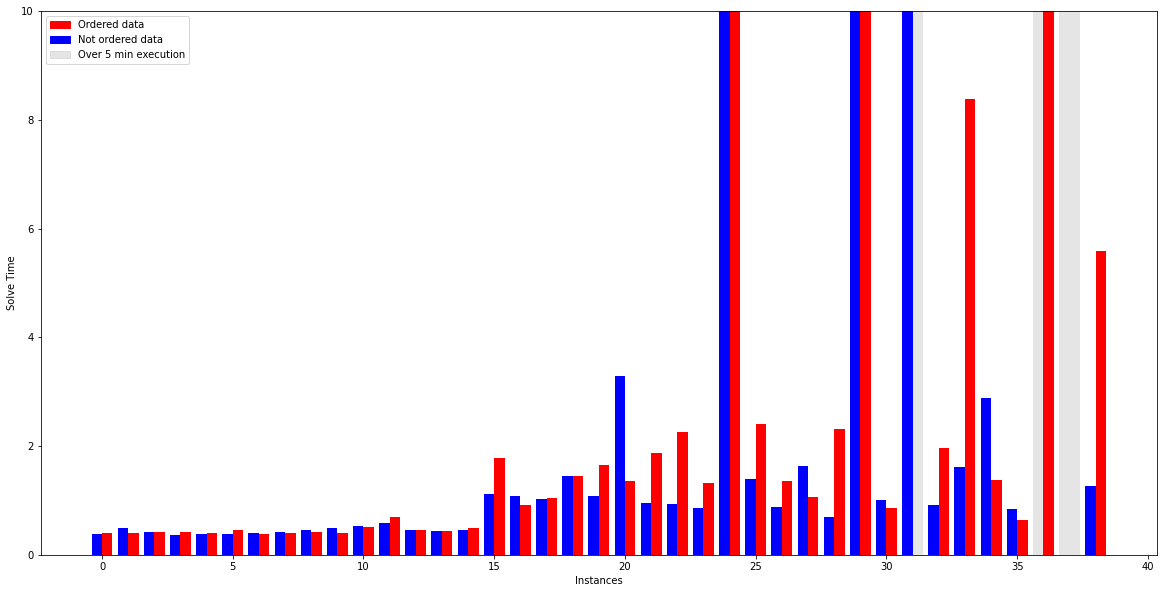

###################################################

Total solving time (ordered data): 786.6705119609833
Total solving time (not ordered): 749.1561160087585
Mean solving time (ordered data): 20.17103876823034
Mean solving time (not ordered): 19.209131179711758

###################################################


In [57]:
width=0.4
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(num_entries)
rect1 = ax.bar(index- width/2, no_ordering_time, width, label="No ordering", color=colors_no_ordering)
rect2 = ax.bar(index + width/2, ordering_time, width, label="Ordering", color=colors_ordering)

ax.set_ylabel("Solve Time")
ax.set_xlabel("Instances")
ax.set_ylim(0, 10)
ax.legend(handles=[order_patch, no_order_patch, over5_patch])

plt.show()

print("###################################################")
print()
print("Total solving time (ordered data): {}".format(total_ordered_time))
print("Total solving time (not ordered): {}".format(total_no_order_time))
print("Mean solving time (ordered data): {}".format(mean_ordering_time))
print("Mean solving time (not ordered): {}".format(mean_no_ordering_time))
print()
print("###################################################")
